In [2]:
import syft as sy
duet = sy.join_duet(loopback=True)

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 


[2021-10-10T13:23:47.501333-0400][CRITICAL][logger]][12638] Skipping torchvision.torchvision.datasets.Omniglot not supported in 0.8.0a0
[2021-10-10T13:23:47.502263-0400][CRITICAL][logger]][12638] Skipping torchvision.torchvision.datasets.Omniglot.__len__ not supported in 0.8.0a0
[2021-10-10T13:23:47.503064-0400][CRITICAL][logger]][12638] Skipping torchvision.torchvision.datasets.Places365 not supported in 0.8.0a0
[2021-10-10T13:23:47.504331-0400][CRITICAL][logger]][12638] Skipping torchvision.torchvision.datasets.Places365.__len__ not supported in 0.8.0a0
[2021-10-10T13:23:47.508666-0400][CRITICAL][logger]][12638] Skipping torchvision.torchvision.transforms.GaussianBlur not supported in 0.8.0a0
[2021-10-10T13:23:47.511083-0400][CRITICAL][logger]][12638] Skipping torchvision.torchvision.transforms.ConvertImageDtype not supported in 0.8.0a0
[2021-10-10T13:23:47.513317-0400][CRITICAL][logger]][12638] Skipping torchvision.torchvision.transforms.functional.adjust_sharpness not supported in 

♫♫♫ > DONE!


/Users/robertbrown/opt/anaconda3/envs/farm/lib/python3.9/site-packages/aiortc/rtcdtlstransport.py:211: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  _openssl_assert(lib.SSL_CTX_use_certificate(ctx, self._cert._x509) == 1)  # type: ignore
/Users/robertbrown/opt/anaconda3/envs/farm/lib/python3.9/site-packages/aiortc/rtcdtlstransport.py:186: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  value=certificate_digest(self._cert._x509),  # type: ignore
[2021-10-10T13:23:48.842341-0400][CRITICAL][logger]][12638] Skipping torchvision.torchvision.datasets.Omniglot not supported in 0.8.0a0
[2021-10-10T13:23:48.843402-0400][CRITICAL][logger]][12638] Skipping torchvision.torchvision.datasets.Omniglot.__len__ not supported in 0.8.0a0
[2021-10-10T13:23:48.844593-0400][CRITICAL][logger]][12638] Skipping torchvision.torchvision.datasets


♫♫♫ > CONNECTED!


In [4]:
#Check for sent data and review tag/description

duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: 47349c147483439c88dda2ab93473581>,[Farm sensor data],"This is a dataset for wheat yield of 359,427 e...",<class 'torch.Tensor'>
1,<UID: d97fa08cf8c64a1197ab93c3eab2c1c2>,[Wheat yield labels],Labels for wheat yield. 0 = low yield. 1 = hig...,<class 'torch.Tensor'>


In [5]:
#View descriptions of the data 

print(duet.store.pandas["Description"][0])
print()
print(duet.store.pandas["Description"][1])

This is a dataset for wheat yield of 359,427 examples using 10 features w/ IoT sensor data.

Labels for wheat yield. 0 = low yield. 1 = high yield


In [6]:
# Assign variables to pointers of the sent data 
data_ptr = duet.store[0]
target_ptr = duet.store[1]

In [7]:
#Show pointer objects 

print(data_ptr)
print(target_ptr)

In [8]:
import torch 

In [9]:
#The data owner must provide this information to the data scientist 

in_dim = 10 # number of features
out_dim = 2 # number of classes 
n_samples = 359427 # number of examples 

In [10]:
# Create model 

class SyNet(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.layer1 = self.torch_ref.nn.Linear(in_dim, 20)
        self.layer2 = self.torch_ref.nn.Linear(20, 30)
        self.out = self.torch_ref.nn.Linear(30, out_dim)

    def forward(self, x):
        x = self.torch_ref.nn.functional.relu(self.layer1(x))
        x = self.torch_ref.nn.functional.relu(self.layer2(x))
        output = self.torch_ref.nn.functional.log_softmax(self.out(x), dim=1)
        return output

In [11]:
#Create local model variable
local_model = SyNet(torch)

In [12]:
#Send local model to data owner
remote_model = local_model.send(duet)

In [13]:
# Alias for duet partners torch
remote_torch = duet.torch

In [14]:
params = remote_model.parameters()
optim = remote_torch.optim.Adam(params=params, lr=0.01)
print("params:", params)
print("optim:", optim)

params: <syft.proxy.syft.lib.python.ListPointer object at 0x7fcea15f53d0>
optim: <syft.proxy.torch.optim.AdamPointer object at 0x7fcea891beb0>


In [15]:
def train(iterations, model, torch_ref, optim, data_ptr, target_ptr):

    losses = []

    for i in range(iterations):

        optim.zero_grad()

        output = model(data_ptr)

        loss = torch_ref.nn.functional.nll_loss(output, target_ptr.long())

        loss_item = loss.item()

        loss_value = loss_item.get(
            reason="Need loss value for training model", request_block=True, timeout_secs=5
        )
        if i % 10 == 0:
            print("Epoch", i, "loss", loss_value)

        losses.append(loss_value)

        loss.backward()

        optim.step()

    return losses

In [16]:
# Run the model 
iteration = 100
losses = train(iteration, remote_model, remote_torch, optim, data_ptr, target_ptr)

Epoch 0 loss 0.7080283761024475
Epoch 10 loss 0.5898525714874268
Epoch 20 loss 0.5566481351852417
Epoch 30 loss 0.5449772477149963
Epoch 40 loss 0.531931459903717
Epoch 50 loss 0.5179024338722229
Epoch 60 loss 0.5065684914588928
Epoch 70 loss 0.49947911500930786
Epoch 80 loss 0.4945535361766815
Epoch 90 loss 0.49089372158050537


Text(0.5, 0, 'iteration')

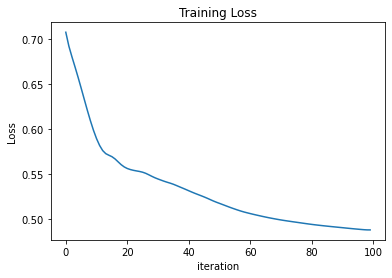

In [17]:
#Create visualization of training loss over each iteration 
import matplotlib.pyplot as plt
plt.plot(range(iteration), losses)
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("iteration")

In [18]:
#After the model is trained, we ask the data owner for permission to get the local model

def get_local_model(model):
    if not model.is_local:
        local_model = model.get(
            request_block=True,
            reason="To run test and inference locally",
            timeout_secs=5,
        )
    else:
        local_model = model

    return local_model


local_model = get_local_model(remote_model)

In [19]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [20]:
import os
os.chdir('data')

df = pd.read_csv("wheat-2014-supervised.csv")

In [21]:
conditions = [
    (df['Yield'] <= 31),
    (df['Yield'] > 31)
    ]

# Classes 
values = [0,1]

df['Yield_Cat'] = np.select(conditions, values)


In [22]:
df['EstDistEquator'] = df['Latitude'] * 69

data_new = df[['EstDistEquator','precipTypeIsOther','temperatureMax','NDVI','visibility','dewPoint','pressure','humidity','cloudCover','windSpeed', 'Yield_Cat' ]]
data_new = data_new.dropna(axis=0)

y = data_new[['Yield_Cat']]
x = data_new.drop(['Yield_Cat'],axis=1)

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())   
])

x = num_pipeline.fit_transform(x)

In [24]:
x_test = torch.FloatTensor(np.array(x))
y = y.to_numpy()
y_test = torch.FloatTensor(y).reshape(-1)


In [25]:
# Test Accuracy 

preds = []
with torch.no_grad():
    for i in range(len(x_test)):
        sample = x_test[i]
        y_hat = local_model(sample.unsqueeze(0))
        pred = y_hat.argmax().item()
        #print(f"Prediction: {pred} Actual: {y_test[i]}")
        preds.append(pred)

In [26]:
acc = accuracy_score(y_test, preds)
print("Overall accuracy", acc * 100)

Overall accuracy 76.3614309707022
